#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [1]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, GRU, Dense, Activation,Input
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time,os

In [2]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')



Mounted at /content/gdrive/


In [3]:

cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [126]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

In [5]:
#Setear semilla
np.random.seed(42)

#Resultados

# MLP

##Exportar resultados Narx

In [6]:
result_mlp=pd.read_csv('results_MLP_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
488,488,MLP_CE_98_4_800_70.0_3.0_416.0_0.67_adam_2.437...,98,4,5.377616,0.375814,0.613037,0.460232,203.494705
68,68,MLP_CE_14_4_800_40.0_3.0_320.0_0.52_adam_1.691...,14,4,6.487561,0.379791,0.616272,0.465164,213.475876
489,489,MLP_CE_98_5_800_70.0_3.0_416.0_0.67_adam_2.437...,98,5,9.411418,0.380050,0.616482,0.460444,190.512939
354,354,MLP_CE_71_5_800_30.0_3.0_192.0_0.67_adam_3.812...,71,5,9.018559,0.380055,0.616486,0.465961,182.855652
322,322,MLP_CE_65_3_800_30.0_3.0_160.0_0.42_adam_1.761...,65,3,10.069403,0.382736,0.618656,0.466213,194.553406


In [7]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'MLP_CE_98_4_800_70.0_3.0_416.0_0.67_adam_2.4379520373693085e-05'

In [8]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_MLP'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [9]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.110470799235103e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


## Generar Narmax data


In [10]:
def narmax_data(data,modelo,predictor,retrasos):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  target = np.array(target_variables)
  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[retrasos:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [11]:
df=narmax_data(df,loaded_model,predictor_variables,3)
df

45/45 [==============================] - 0s 2ms/step


,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,error
dt,,,,,,,,
2006-12-19,0.165544,0.181727,-0.526763,0.566945,-0.478415,2.753617,-0.799143,-1.446839
2006-12-20,1.085635,1.062706,-0.327783,0.717836,-1.006562,0.380121,1.263615,0.541239
2006-12-21,0.249270,0.239930,-0.660841,0.099227,0.104498,0.368143,0.308547,-0.350538
2006-12-22,1.275703,1.294563,0.184862,0.168754,0.976980,-0.720867,0.494736,0.811671
2006-12-23,5.274789,5.385178,0.868785,-0.343654,0.673563,-0.684934,1.437479,4.455368
...,...,...,...,...,...,...,...,...
2010-11-22,0.782730,0.803613,-0.696695,-0.313822,2.049641,0.122362,0.233810,1.099480
2010-11-23,0.019761,0.037690,-0.793731,-0.128886,0.171225,-0.669123,-0.428340,-0.626181
2010-11-24,0.379396,0.366498,-0.892469,-0.395024,-0.316634,0.475942,0.781361,0.378100


##3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [13]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [14]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [15]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [16]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [17]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [18]:
predictor_variables.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),error(t-2),error(t-1),error(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-22,0.165544,1.085635,0.249270,0.181727,1.062706,0.239930,-0.526763,-0.327783,-0.660841,0.566945,...,0.104498,2.753617,0.380121,0.368143,-0.799143,1.263615,0.308547,-1.446839,0.541239,-0.350538
2006-12-23,1.085635,0.249270,1.275703,1.062706,0.239930,1.294563,-0.327783,-0.660841,0.184862,0.717836,...,0.976980,0.380121,0.368143,-0.720867,1.263615,0.308547,0.494736,0.541239,-0.350538,0.811671
2006-12-24,0.249270,1.275703,5.274789,0.239930,1.294563,5.385178,-0.660841,0.184862,0.868785,0.099227,...,0.673563,0.368143,-0.720867,-0.684934,0.308547,0.494736,1.437479,-0.350538,0.811671,4.455368
2006-12-25,1.275703,5.274789,1.618832,1.294563,5.385178,1.733345,0.184862,0.868785,-0.547381,0.168754,...,0.065470,-0.720867,-0.684934,1.546268,0.494736,1.437479,-0.617150,0.811671,4.455368,-0.680768
2006-12-26,5.274789,1.618832,1.936365,5.385178,1.733345,1.911208,0.868785,-0.547381,1.240982,-0.343654,...,3.160702,-0.684934,1.546268,0.051454,1.437479,-0.617150,-0.904563,4.455368,-0.680768,0.630218


In [19]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


##Exportar resultados Narmax


In [23]:
result_mlp=pd.read_csv('Narmax_results_MLP_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
459,459,MLP_CE_92_5_800_20.0_2.0_256.0_0.61_adam_4.110...,92,5,10.724492,0.346373,0.588535,0.444450,375.019867
279,279,MLP_CE_56_5_800_80.0_3.0_160.0_0.56_adam_1.324...,56,5,9.945225,0.351513,0.592885,0.445533,352.232330
33,33,MLP_CE_7_4_800_80.0_2.0_480.0_0.65_adam_2.8387...,7,4,4.404431,0.351551,0.592918,0.445643,387.411224
54,54,MLP_CE_11_5_800_10.0_2.0_544.0_0.48_adam_4.047...,11,5,15.854931,0.351660,0.593009,0.447140,428.875153
64,64,MLP_CE_13_5_800_20.0_1.0_256.0_0.49_adam_3.685...,13,5,27.562203,0.351895,0.593208,0.446939,393.507904


In [24]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'MLP_CE_92_5_800_20.0_2.0_256.0_0.61_adam_4.110470799235103e-05'

In [25]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/Narmax_result_MLP'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [26]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.110470799235103e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [28]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


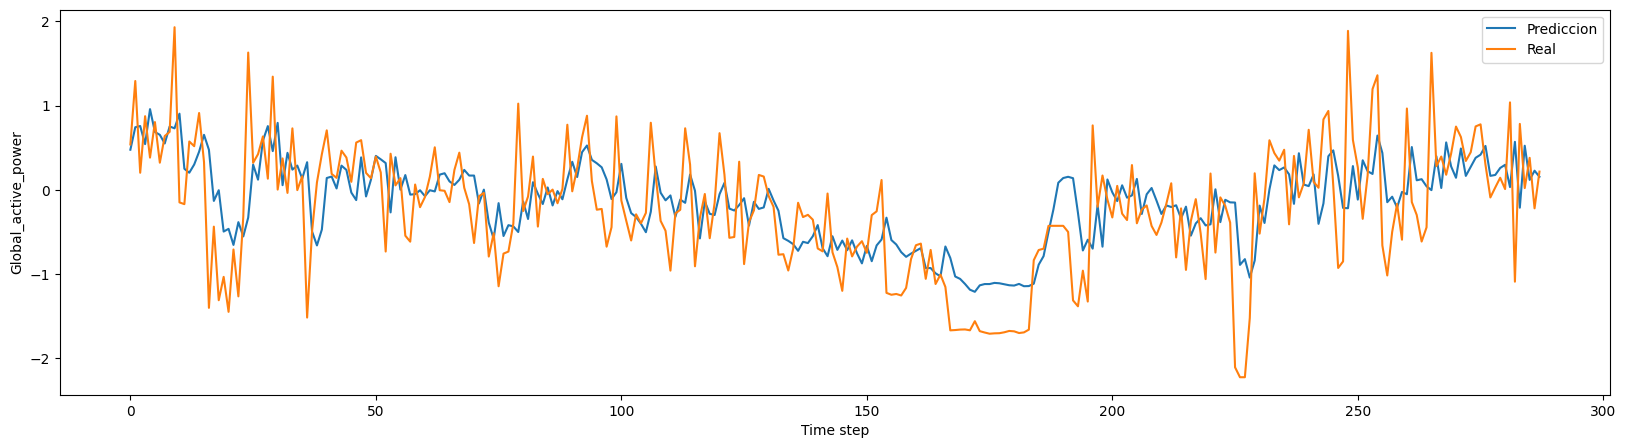

In [29]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

#CNN

##Exportar resultados Narx

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

In [127]:
result_mlp=pd.read_csv('results_CNN_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
173,173,CNN_CE_800_60.0_2.0_100.0_0.63_adam_3.21510030...,35,4,7.002579,0.372284,0.610150,0.447380,193.632339
343,343,CNN_CE_800_60.0_2.0_200.0_0.64_adam_2.54716769...,69,4,11.349024,0.372287,0.610153,0.453491,194.921432
279,279,CNN_CE_800_70.0_2.0_100.0_0.62_adam_1.53838502...,56,5,16.170364,0.372849,0.610613,0.448964,188.639374
394,394,CNN_CE_800_20.0_2.0_100.0_0.67_adam_4.88524469...,79,5,12.009378,0.373540,0.611179,0.450430,187.399948
333,333,CNN_CE_800_60.0_2.0_100.0_0.7_adam_2.909277765...,67,4,17.459790,0.375022,0.612391,0.447587,187.844406


In [128]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo="CNN_CE_800_10.0_2.0_200.0_0.58_adam_2.673342910357679e-05_2_192.0"

In [129]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_CNN'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [130]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.2151003059981485e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


## Generar Narmax data


In [131]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor=np.array(predictor_variables)
predictor= predictor.reshape((predictor_variables.shape[0], predictor_variables.shape[1],1))
shape_target=target_variables.shape

In [132]:
def narmax_data(data,modelo,predictor,shape_target,retrasos):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)
  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[retrasos:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [133]:
df=narmax_data(df,loaded_model,predictor,shape_target,3)
df

45/45 [==============================] - 0s 3ms/step


,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,error
dt,,,,,,,,
2006-12-19,0.165544,0.181727,-0.526763,0.566945,-0.478415,2.753617,-0.799143,-1.738637
2006-12-20,1.085635,1.062706,-0.327783,0.717836,-1.006562,0.380121,1.263615,0.159612
2006-12-21,0.249270,0.239930,-0.660841,0.099227,0.104498,0.368143,0.308547,-0.259179
2006-12-22,1.275703,1.294563,0.184862,0.168754,0.976980,-0.720867,0.494736,0.924258
2006-12-23,5.274789,5.385178,0.868785,-0.343654,0.673563,-0.684934,1.437479,4.479939
...,...,...,...,...,...,...,...,...
2010-11-22,0.782730,0.803613,-0.696695,-0.313822,2.049641,0.122362,0.233810,0.926923
2010-11-23,0.019761,0.037690,-0.793731,-0.128886,0.171225,-0.669123,-0.428340,-0.379211
2010-11-24,0.379396,0.366498,-0.892469,-0.395024,-0.316634,0.475942,0.781361,0.460491


##3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [134]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [135]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [136]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [137]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [138]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [139]:
predictor_variables.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),error(t-2),error(t-1),error(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-22,0.165544,1.085635,0.249270,0.181727,1.062706,0.239930,-0.526763,-0.327783,-0.660841,0.566945,...,0.104498,2.753617,0.380121,0.368143,-0.799143,1.263615,0.308547,-1.738637,0.159612,-0.259179
2006-12-23,1.085635,0.249270,1.275703,1.062706,0.239930,1.294563,-0.327783,-0.660841,0.184862,0.717836,...,0.976980,0.380121,0.368143,-0.720867,1.263615,0.308547,0.494736,0.159612,-0.259179,0.924258
2006-12-24,0.249270,1.275703,5.274789,0.239930,1.294563,5.385178,-0.660841,0.184862,0.868785,0.099227,...,0.673563,0.368143,-0.720867,-0.684934,0.308547,0.494736,1.437479,-0.259179,0.924258,4.479939
2006-12-25,1.275703,5.274789,1.618832,1.294563,5.385178,1.733345,0.184862,0.868785,-0.547381,0.168754,...,0.065470,-0.720867,-0.684934,1.546268,0.494736,1.437479,-0.617150,0.924258,4.479939,-0.697055
2006-12-26,5.274789,1.618832,1.936365,5.385178,1.733345,1.911208,0.868785,-0.547381,1.240982,-0.343654,...,3.160702,-0.684934,1.546268,0.051454,1.437479,-0.617150,-0.904563,4.479939,-0.697055,0.401945


In [140]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


##Exportar resultados Narmax


In [141]:
result_mlp=pd.read_csv('Narmax_results_MLP_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
459,459,MLP_CE_92_5_800_20.0_2.0_256.0_0.61_adam_4.110...,92,5,10.724492,0.346373,0.588535,0.444450,375.019867
279,279,MLP_CE_56_5_800_80.0_3.0_160.0_0.56_adam_1.324...,56,5,9.945225,0.351513,0.592885,0.445533,352.232330
33,33,MLP_CE_7_4_800_80.0_2.0_480.0_0.65_adam_2.8387...,7,4,4.404431,0.351551,0.592918,0.445643,387.411224
54,54,MLP_CE_11_5_800_10.0_2.0_544.0_0.48_adam_4.047...,11,5,15.854931,0.351660,0.593009,0.447140,428.875153
64,64,MLP_CE_13_5_800_20.0_1.0_256.0_0.49_adam_3.685...,13,5,27.562203,0.351895,0.593208,0.446939,393.507904


In [142]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'MLP_CE_92_5_800_20.0_2.0_256.0_0.61_adam_4.110470799235103e-05'

In [143]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/Narmax_result_MLP'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [144]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.110470799235103e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [145]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


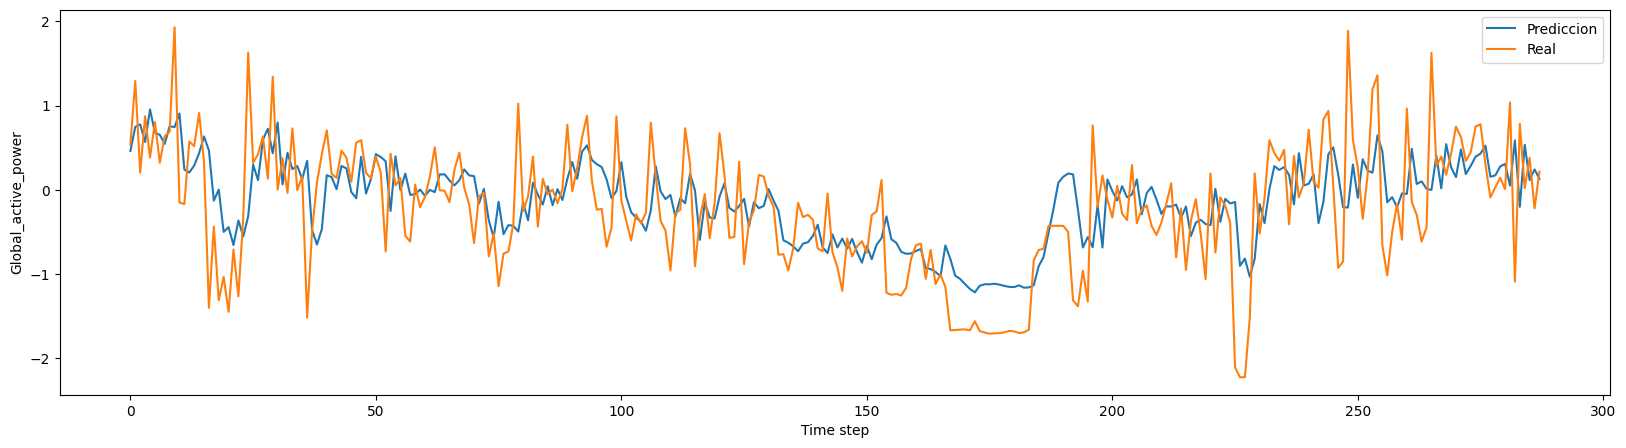

In [146]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

In [147]:
#Metricas de precision del modelo keras
score = loaded_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3453410863876343
RMSE: 0.5876572728157043
MAE: 0.44418132305145264
MAPE: 373.2515869140625


#GRU

##Exportar resultados Narx

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

In [78]:
result_mlp=pd.read_csv('results_GRU_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
334,334,GRU_CE_67_5_800_10.0_3.0_500.0_0.49_adam_0.000...,67,5,27.252400,0.358205,0.598502,0.440844,194.151001
424,424,GRU_CE_85_5_800_10.0_2.0_800.0_0.54_adam_0.000...,85,5,20.559656,0.362767,0.602301,0.443280,186.456909
484,484,GRU_CE_97_5_800_10.0_3.0_400.0_0.47_adam_0.000...,97,5,25.128468,0.369431,0.607808,0.456008,192.567245
64,64,GRU_CE_13_5_800_50.0_2.0_800.0_0.63_adam_0.000...,13,5,9.445666,0.373207,0.610907,0.448703,204.133591
199,199,GRU_CE_40_5_800_20.0_2.0_540.0_0.7_adam_0.0001...,40,5,17.485842,0.374655,0.612090,0.455858,204.192612


In [79]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'GRU_CE_67_5_800_10.0_3.0_500.0_0.49_adam_0.0004874858675338587'

In [82]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_GRU'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [83]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0004874858675338587), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


## Generar Narmax data


In [88]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor=np.array(predictor_variables)
predictor= predictor.reshape((predictor_variables.shape[0], 1,predictor_variables.shape[1]))
shape_target=target_variables.shape

In [85]:
def narmax_data(data,modelo,predictor,shape_target,retrasos):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)
  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[retrasos:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [89]:
df=narmax_data(df,loaded_model,predictor,shape_target,3)
df

45/45 [==============================] - 2s 13ms/step


,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,error
dt,,,,,,,,
2006-12-19,0.165544,0.181727,-0.526763,0.566945,-0.478415,2.753617,-0.799143,-1.165974
2006-12-20,1.085635,1.062706,-0.327783,0.717836,-1.006562,0.380121,1.263615,0.347788
2006-12-21,0.249270,0.239930,-0.660841,0.099227,0.104498,0.368143,0.308547,-0.407126
2006-12-22,1.275703,1.294563,0.184862,0.168754,0.976980,-0.720867,0.494736,1.007603
2006-12-23,5.274789,5.385178,0.868785,-0.343654,0.673563,-0.684934,1.437479,4.246092
...,...,...,...,...,...,...,...,...
2010-11-22,0.782730,0.803613,-0.696695,-0.313822,2.049641,0.122362,0.233810,0.807916
2010-11-23,0.019761,0.037690,-0.793731,-0.128886,0.171225,-0.669123,-0.428340,-0.408066
2010-11-24,0.379396,0.366498,-0.892469,-0.395024,-0.316634,0.475942,0.781361,0.159180


##3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [90]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [91]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [92]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [93]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [94]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [95]:
predictor_variables.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),error(t-2),error(t-1),error(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-22,0.165544,1.085635,0.249270,0.181727,1.062706,0.239930,-0.526763,-0.327783,-0.660841,0.566945,...,0.104498,2.753617,0.380121,0.368143,-0.799143,1.263615,0.308547,-1.165974,0.347788,-0.407126
2006-12-23,1.085635,0.249270,1.275703,1.062706,0.239930,1.294563,-0.327783,-0.660841,0.184862,0.717836,...,0.976980,0.380121,0.368143,-0.720867,1.263615,0.308547,0.494736,0.347788,-0.407126,1.007603
2006-12-24,0.249270,1.275703,5.274789,0.239930,1.294563,5.385178,-0.660841,0.184862,0.868785,0.099227,...,0.673563,0.368143,-0.720867,-0.684934,0.308547,0.494736,1.437479,-0.407126,1.007603,4.246092
2006-12-25,1.275703,5.274789,1.618832,1.294563,5.385178,1.733345,0.184862,0.868785,-0.547381,0.168754,...,0.065470,-0.720867,-0.684934,1.546268,0.494736,1.437479,-0.617150,1.007603,4.246092,-0.460081
2006-12-26,5.274789,1.618832,1.936365,5.385178,1.733345,1.911208,0.868785,-0.547381,1.240982,-0.343654,...,3.160702,-0.684934,1.546268,0.051454,1.437479,-0.617150,-0.904563,4.246092,-0.460081,0.983707


In [114]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


##Exportar resultados Narmax


In [115]:
result_mlp=pd.read_csv('Narmax_results_GRU_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
324,324,GRU_65_5_800_40.0_2.0_480.0_0.66_adam_0.000302...,65,5,11.981645,0.332557,0.576678,0.429404,376.327942
19,19,GRU_4_5_800_20.0_3.0_460.0_0.53_adam_0.0003537...,4,5,17.638860,0.333403,0.577411,0.431432,391.568390
219,219,GRU_44_5_800_20.0_3.0_380.0_0.58_adam_0.000308...,44,5,22.107000,0.333685,0.577655,0.431108,370.271149
359,359,GRU_72_5_800_20.0_2.0_560.0_0.66_adam_0.000381...,72,5,14.394235,0.336140,0.579776,0.434814,364.590485
329,329,GRU_66_5_800_20.0_2.0_740.0_0.62_adam_0.000392...,66,5,14.380414,0.336286,0.579902,0.434847,367.457336


In [116]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo="GRU_CE_65_5_800_40.0_2.0_480.0_0.66_adam_0.00030231941968913057"

In [117]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/Narmax_result_GRU'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [118]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.110470799235103e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [119]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0], 1, Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [120]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 1s 8ms/step


In [121]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

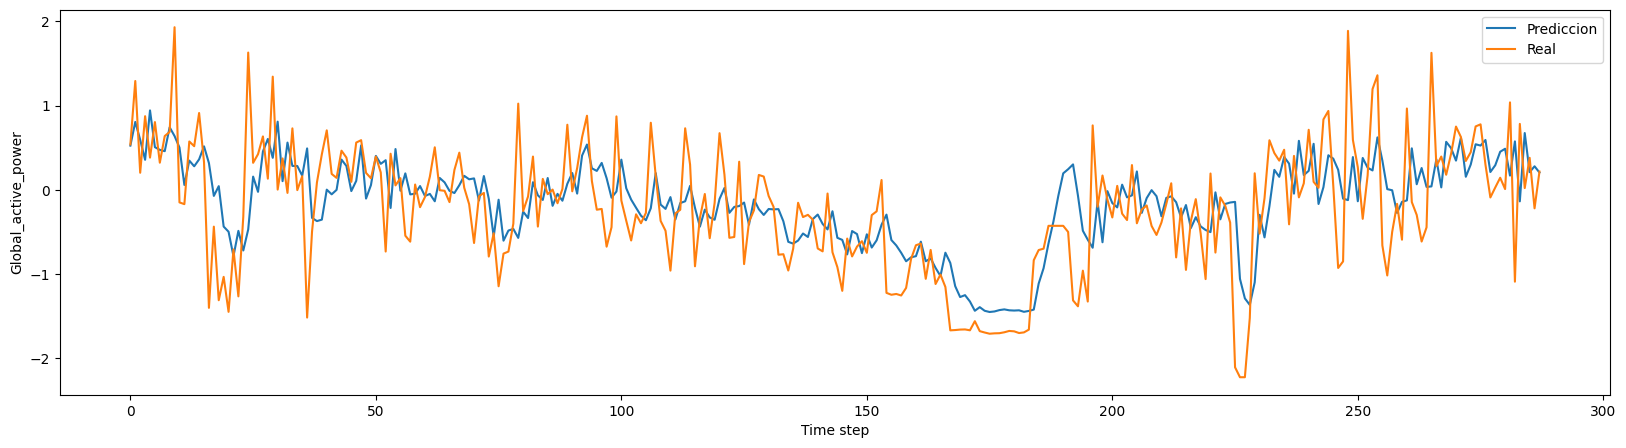

In [123]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

In [125]:
#Metricas de precision del modelo keras
score = loaded_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3325579762458801
RMSE: 0.5766783952713013
MAE: 0.4294045567512512
MAPE: 376.3905029296875


#LSTM

##Exportar resultados Narx

In [189]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

In [190]:
result_mlp=pd.read_csv('results_LSTM_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
139,139,LSTM_CE_800_10.0_1.0_680.0_0.52_adam_3.1458576...,28,5,36.681360,0.378168,0.614954,0.455236,220.871017
319,319,LSTM_CE_800_10.0_1.0_640.0_0.42_adam_4.4268419...,64,5,28.392772,0.379389,0.615946,0.456227,220.155869
299,299,LSTM_CE_800_20.0_1.0_780.0_0.68_adam_4.2855902...,60,5,23.493317,0.380622,0.616946,0.457438,223.087753
94,94,LSTM_CE_800_30.0_1.0_620.0_0.55_adam_3.4341560...,19,5,20.831620,0.380932,0.617197,0.456960,224.679672
499,499,LSTM_CE_800_20.0_2.0_480.0_0.54_adam_1.6602774...,100,5,51.668610,0.380971,0.617228,0.457549,221.807846


In [194]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'LSTM_CE_800_10.0_1.0_680.0_0.52_adam_3.1458576754462924e-05'

In [198]:
nombre_archivo="LSTM_CE_28_5_800_10.0_1.0_680.0_0.52_adam_3.1458576754462924e-05"

In [199]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_LSTM'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [200]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0004874858675338587), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


## Generar Narmax data


In [201]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor=np.array(predictor_variables)
predictor= predictor.reshape((predictor_variables.shape[0], 1,predictor_variables.shape[1]))
shape_target=target_variables.shape

In [202]:
def narmax_data(data,modelo,predictor,shape_target,retrasos):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)
  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[retrasos:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [203]:
df=narmax_data(df,loaded_model,predictor,shape_target,3)
df

45/45 [==============================] - 1s 8ms/step


,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,error
dt,,,,,,,,
2006-12-19,0.165544,0.181727,-0.526763,0.566945,-0.478415,2.753617,-0.799143,-1.254968
2006-12-20,1.085635,1.062706,-0.327783,0.717836,-1.006562,0.380121,1.263615,0.510560
2006-12-21,0.249270,0.239930,-0.660841,0.099227,0.104498,0.368143,0.308547,-0.446418
2006-12-22,1.275703,1.294563,0.184862,0.168754,0.976980,-0.720867,0.494736,0.969621
2006-12-23,5.274789,5.385178,0.868785,-0.343654,0.673563,-0.684934,1.437479,4.181905
...,...,...,...,...,...,...,...,...
2010-11-22,0.782730,0.803613,-0.696695,-0.313822,2.049641,0.122362,0.233810,0.980356
2010-11-23,0.019761,0.037690,-0.793731,-0.128886,0.171225,-0.669123,-0.428340,-0.725917
2010-11-24,0.379396,0.366498,-0.892469,-0.395024,-0.316634,0.475942,0.781361,0.297129


##3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [204]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [205]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [206]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [207]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [208]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [209]:
predictor_variables.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),error(t-2),error(t-1),error(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-22,0.165544,1.085635,0.249270,0.181727,1.062706,0.239930,-0.526763,-0.327783,-0.660841,0.566945,...,0.104498,2.753617,0.380121,0.368143,-0.799143,1.263615,0.308547,-1.254968,0.510560,-0.446418
2006-12-23,1.085635,0.249270,1.275703,1.062706,0.239930,1.294563,-0.327783,-0.660841,0.184862,0.717836,...,0.976980,0.380121,0.368143,-0.720867,1.263615,0.308547,0.494736,0.510560,-0.446418,0.969621
2006-12-24,0.249270,1.275703,5.274789,0.239930,1.294563,5.385178,-0.660841,0.184862,0.868785,0.099227,...,0.673563,0.368143,-0.720867,-0.684934,0.308547,0.494736,1.437479,-0.446418,0.969621,4.181905
2006-12-25,1.275703,5.274789,1.618832,1.294563,5.385178,1.733345,0.184862,0.868785,-0.547381,0.168754,...,0.065470,-0.720867,-0.684934,1.546268,0.494736,1.437479,-0.617150,0.969621,4.181905,-0.680078
2006-12-26,5.274789,1.618832,1.936365,5.385178,1.733345,1.911208,0.868785,-0.547381,1.240982,-0.343654,...,3.160702,-0.684934,1.546268,0.051454,1.437479,-0.617150,-0.904563,4.181905,-0.680078,1.154632


In [210]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


##Exportar resultados Narmax


In [245]:
result_mlp=pd.read_csv('Narmax_results_LSTM_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
4,4,LSTM_CE_1_5_800_90_1_100_0.69_adam_1.009224357...,1,5,60.136909,0.362226,0.601852,0.448478,420.768036
3,3,LSTM_CE_1_4_800_90_1_100_0.69_adam_1.009224357...,1,4,34.146364,0.381413,0.617586,0.466746,416.832397
1,1,LSTM_CE_1_2_800_90_1_100_0.69_adam_1.009224357...,1,2,48.999762,0.405976,0.637163,0.484218,431.966858
2,2,LSTM_CE_1_3_800_90_1_100_0.69_adam_1.009224357...,1,3,55.191955,0.422390,0.649916,0.492361,520.818359
0,0,LSTM_CE_1_1_800_90_1_100_0.69_adam_1.009224357...,1,1,45.439553,0.444992,0.667077,0.516479,264.664093


In [246]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'LSTM_CE_1_5_800_90_1_100_0.69_adam_1.0092243575868021e-05'

In [249]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/Narmax_result_lstm'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [250]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.110470799235103e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [251]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0], 1, Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [252]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 0s 3ms/step


In [253]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

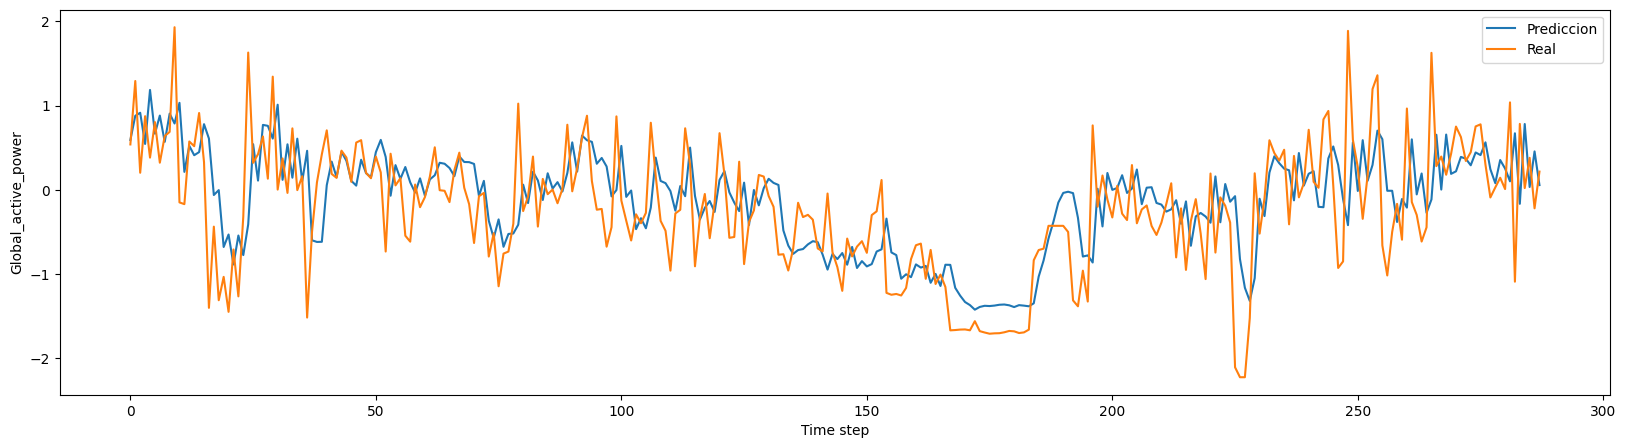

In [254]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

In [255]:
#Metricas de precision del modelo keras
score = loaded_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.36070287227630615
RMSE: 0.6005854606628418
MAE: 0.44656503200531006
MAPE: 417.8979187011719


#Transformer

##Exportar resultados Narx

In [220]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

In [221]:
result_mlp=pd.read_csv('results_Transformer_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,index,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
0,439,Transformer_CE_800_40.0_128.0_6.0_0.64_160.0_3...,88,5,47.148076,0.370745,0.608889,0.442792,215.380447
1,159,Transformer_CE_800_20.0_192.0_6.0_0.59_128.0_4...,32,5,49.049351,0.372243,0.610117,0.453836,239.374893
2,259,Transformer_CE_800_50.0_128.0_5.0_0.47_160.0_2...,52,5,76.609337,0.374506,0.611969,0.451261,210.443329
3,494,Transformer_CE_800_40.0_128.0_6.0_0.61_160.0_3...,99,5,69.508075,0.374999,0.612372,0.450840,214.465591
4,299,Transformer_CE_800_10.0_160.0_6.0_0.59_96.0_4....,60,5,109.001675,0.377282,0.614233,0.453981,207.757339


In [222]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'Transformer_CE_800_40.0_128.0_6.0_0.64_160.0_3.6125042299943215e-05'

In [227]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_Transformer'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [228]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0004874858675338587), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


## Generar Narmax data


In [256]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor=np.array(predictor_variables)
predictor= predictor.reshape((predictor_variables.shape[0], 1,predictor_variables.shape[1]))
shape_target=target_variables.shape

In [257]:
def narmax_data(data,modelo,predictor,shape_target,retrasos):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)
  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[retrasos:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [258]:
df=narmax_data(df,loaded_model,predictor,shape_target,3)
df

45/45 [==============================] - 0s 2ms/step


,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,error
dt,,,,,,,,
2006-12-22,1.275703,1.294563,0.184862,0.168754,0.976980,-0.720867,0.494736,0.802856
2006-12-23,5.274789,5.385178,0.868785,-0.343654,0.673563,-0.684934,1.437479,4.280925
2006-12-24,1.618832,1.733345,-0.547381,0.414525,0.065470,1.546268,-0.617150,0.031186
2006-12-25,1.936365,1.911208,1.240982,1.251453,3.160702,0.051454,-0.904563,1.302724
2006-12-26,3.894744,3.852935,-0.246577,0.384225,-0.322929,0.325024,1.503825,2.198091
...,...,...,...,...,...,...,...,...
2010-11-22,0.782730,0.803613,-0.696695,-0.313822,2.049641,0.122362,0.233810,0.949950
2010-11-23,0.019761,0.037690,-0.793731,-0.128886,0.171225,-0.669123,-0.428340,-0.761382
2010-11-24,0.379396,0.366498,-0.892469,-0.395024,-0.316634,0.475942,0.781361,0.346793


##3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [259]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [260]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [261]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [262]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [263]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [264]:
predictor_variables.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),error(t-2),error(t-1),error(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-25,1.275703,5.274789,1.618832,1.294563,5.385178,1.733345,0.184862,0.868785,-0.547381,0.168754,...,0.065470,-0.720867,-0.684934,1.546268,0.494736,1.437479,-0.617150,0.802856,4.280925,0.031186
2006-12-26,5.274789,1.618832,1.936365,5.385178,1.733345,1.911208,0.868785,-0.547381,1.240982,-0.343654,...,3.160702,-0.684934,1.546268,0.051454,1.437479,-0.617150,-0.904563,4.280925,0.031186,1.302724
2006-12-27,1.618832,1.936365,3.894744,1.733345,1.911208,3.852935,-0.547381,1.240982,-0.246577,0.414525,...,-0.322929,1.546268,0.051454,0.325024,-0.617150,-0.904563,1.503825,0.031186,1.302724,2.198091
2006-12-28,1.936365,3.894744,-0.060442,1.911208,3.852935,-0.052036,1.240982,-0.246577,0.026486,1.251453,...,-1.006562,0.051454,0.325024,-0.738115,-0.904563,1.503825,-0.594860,1.302724,2.198091,-1.308405
2006-12-29,3.894744,-0.060442,0.833872,3.852935,-0.052036,0.844823,-0.246577,0.026486,0.619586,0.384225,...,0.382736,0.325024,-0.738115,1.228620,1.503825,-0.594860,-0.017938,2.198091,-1.308405,0.404975


In [265]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


##Exportar resultados Narmax


In [266]:
result_mlp=pd.read_csv('Narmax_results_Transformer_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,index,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
159,159,Transformer_CE_32_5_800_90.0_128.0_5.0_0.42_19...,32,5,21.404986,0.336877,0.580411,0.418683,401.642548
164,164,Transformer_CE_33_5_800_100.0_128.0_7.0_0.44_1...,33,5,19.589863,0.343960,0.586481,0.428965,380.546997
344,344,Transformer_CE_69_5_800_40.0_96.0_6.0_0.61_224...,69,5,57.999296,0.346943,0.589019,0.433090,468.981171
249,249,Transformer_CE_50_5_800_20.0_64.0_7.0_0.62_224...,50,5,64.240140,0.348265,0.590139,0.435506,374.909058
389,389,Transformer_CE_78_5_800_30.0_160.0_8.0_0.63_16...,78,5,73.150056,0.350094,0.591688,0.434001,436.018036


In [268]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'Transformer_CE_32_5_800_90.0_128.0_5.0_0.42_192.0_4.06386201548327e-05'

In [272]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/Narmax_result_trans'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [279]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=4.06386201548327e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0], 1, Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [281]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 1s 5ms/step


In [282]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

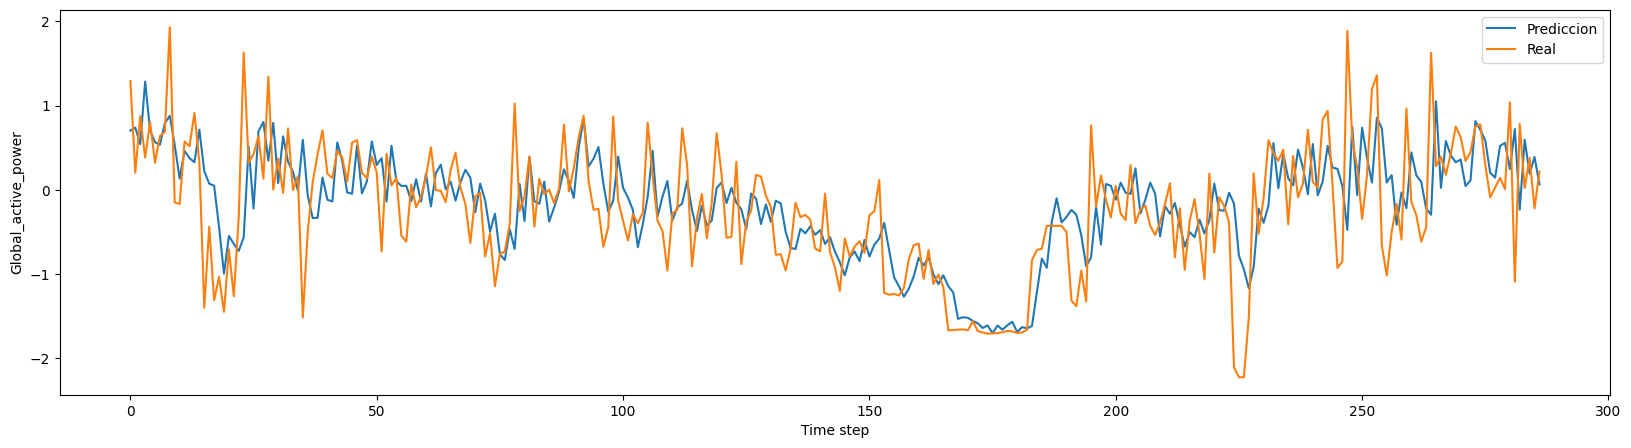

In [283]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

In [284]:
#Metricas de precision del modelo keras
score = loaded_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.34750431776046753
RMSE: 0.5894949436187744
MAE: 0.4256097376346588
MAPE: 417.17462158203125
